In [17]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout, Flatten
import tensorflow_probability as tfp
from tensorflow_probability.python.distributions import Normal
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
tfb = tfp.bijectors
tfd = tfp.distributions

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [19]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_26528\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_26528\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_26528\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [20]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [21]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [22]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [23]:
data = data.dropna()

In [25]:
# Create plots
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

In [26]:
def create_timestamps(data, sequence_lenght):
    X, Y = [], []
    for i in range(sequence_lenght, len(data)):
        X.append(data[i-sequence_lenght:i])
        Y.append(data[i])
    X, Y = np.array(X), np.array(Y)

    return X, Y


In [28]:
# il 2020 inizia a inidce 35068

#train_split = 0.7
n_train = 35088
n_test = int(len(data)-n_train)
window_size = 24

features = ['total_aggregated']
feature_array = data[features].values

# Fit Scaler only on Training features
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_array[:n_train])
# Fit Scaler only on Training target values
target_scaler = MinMaxScaler(feature_range=(-1,1))
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = feature_scaler.transform(feature_array)

# Define helper functions.
detector = IsolationForest(n_estimators=1000, random_state=42)
neg_log_likelihood = lambda scaled_array, rv_x: -rv_x.log_prob(scaled_array)

# Define window size for input data

train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

X_train, y_train = create_timestamps(train_data, 24)
X_test, y_test = create_timestamps(test_data, 24)

# Prepare training data
#X_train, y_train = [], []
#for i in range(window_size, len(train_data)):
#    X_train.append(train_data[i-window_size:i])
#    y_train.append(train_data[i])
#X_train, y_train = np.array(X_train), np.array(y_train)
#
## Prepare test data
#X_test, y_test = [], []
#for i in range(window_size, len(test_data)):
#    X_test.append(test_data[i-window_size:i])
#    y_test.append(test_data[i])
#X_test, y_test = np.array(X_test), np.array(y_test)

In [29]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [9]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input
from keras.models import Model

batch_size = 168
num_batches = n_train / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 0.1, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.0 
}

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)

model = Model(x_in, x)

In [5]:
# Define prior for regularization.
gauss_prior = tfd.Normal(
    loc = tf.zeros(len(test_data), dtype=tf.float64 ),
    scale = 1.0, #tf.ones( len(outputs), dtype=tf.float64 ),
    name = "p_normal",
    )

prior = tfd.Independent(
    gauss_prior,
    reinterpreted_batch_ndims = 1,
    name = "prior",
    )

regularizer = tfp.layers.KLDivergenceRegularizer(prior, weight=1/168, ) # Kullback–Leibler divergence (also called relative entrop

In [9]:
bmlp = Sequential([
    Dense(64, activation='relu', input_shape=(24,)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='relu')
])

In [10]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

bmlp.compile(optimizer=optimizer, loss=loss, metrics = metric)

Epoch 1/50
167/167 [==============================] - 5s 8ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 2/50
167/167 [==============================] - 1s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630
Epoch 3/50
167/167 [==============================] - 1s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 4/50
167/167 [==============================] - 1s 5ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 5/50
167/167 [==============================] - 1s 5ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 6/50
167/167 [==============================] - 1s 6ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0019 - val_

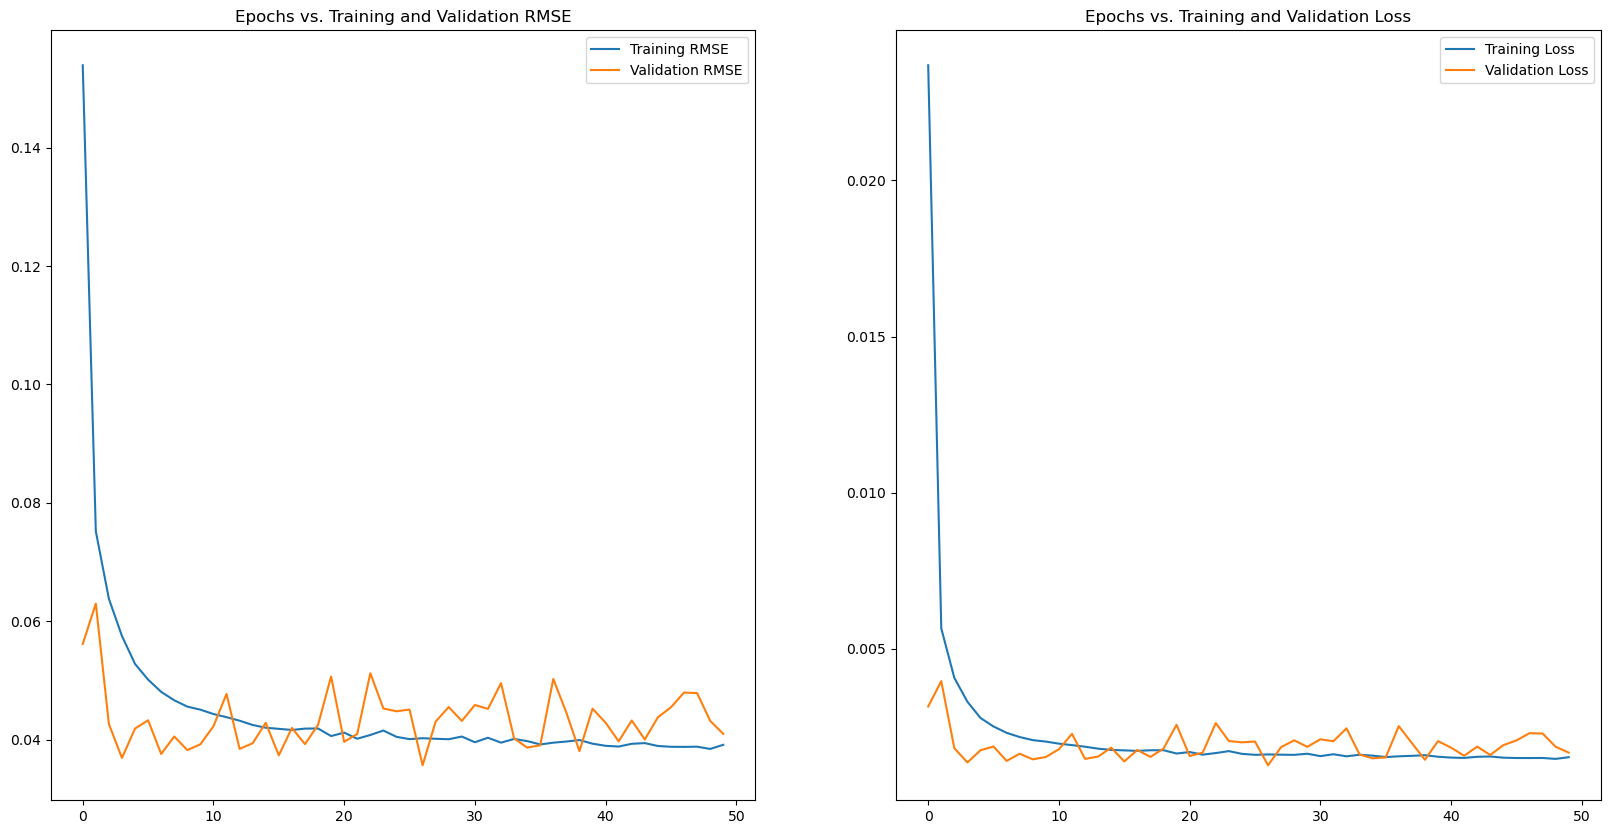

In [11]:
# Fit the model on the training data
history = bmlp.fit(X_train, y_train, epochs=50, batch_size=168, verbose=1, validation_split=0.2)
plot_model_rmse_and_loss(history)

In [14]:
def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

547/547 [==============================] - 1s 911us/step
Root Mean Squared Error for 793.3798333287624


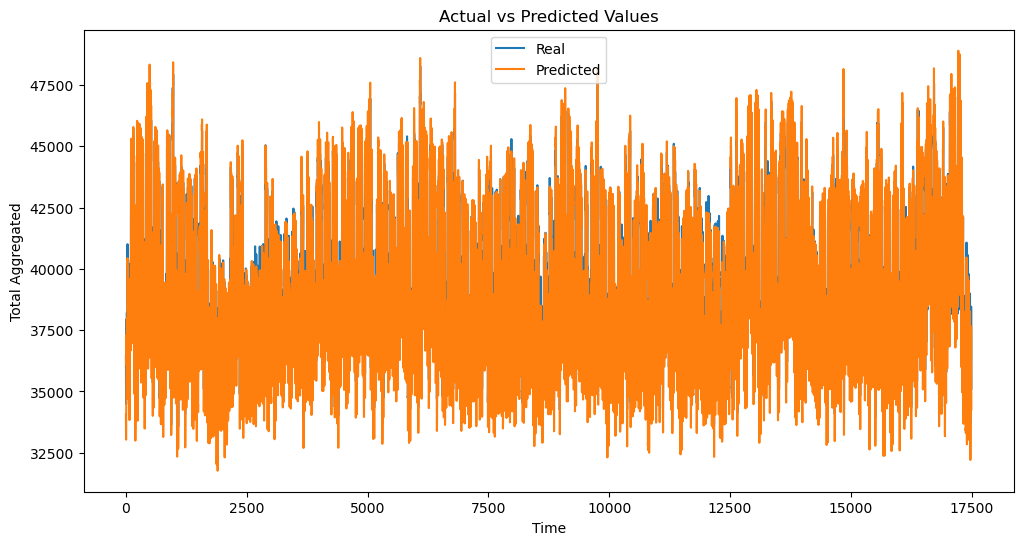

In [19]:
# Make predictions on the test data
y_pred = bmlp.predict(X_test)

## Inverse transform the scaled test data and predictions
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

rmse = sqrt(np.mean((y_test_inv - y_pred_inv)**2))
print('Root Mean Squared Error for', rmse)
# Plot the actual and predicted values
plot_preds_vs_actual(y_pred_inv, y_test_inv)

In [ ]:
print()